Classificacao CNN
=================

1. Aquisição e pré-processamento dos dados
2. Treinamento
    1. Implementar arquitetura
    2. Definir otimizadores, métricas e regularizadores
3. Teste (avaliação de desempenho)

In [1]:
# Imports

import numpy as np
import pathlib
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import torch

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
a = torch.tensor([4,5,6])

## Aquisição e pré-processamento dos dados

In [18]:
path = './../../Datasets/Exercicio_Tumores'
data = pathlib.Path(path)

In [19]:
disease = {
    "glioma_tumor": list(data.glob('glioma_tumor/*.jpg')),
    "meningioma_tumor": list(data.glob('meningioma_tumor/*.jpg')),
    "normal": list(data.glob('normal/*.jpg')),
    "pituitary_tumor" : list(data.glob('pituitary_tumor/*.jpg')),       
}

labels = {
    "glioma_tumor" : 0,
    "meningioma_tumor":1,
    "normal":2,
    "pituitary_tumor":3
}

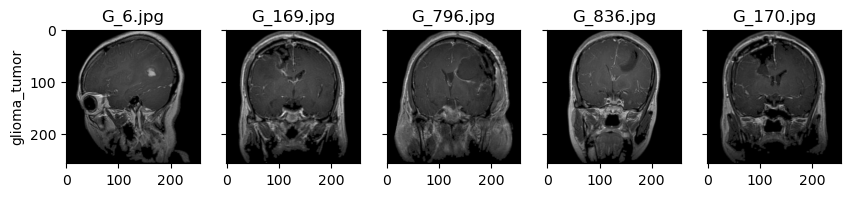

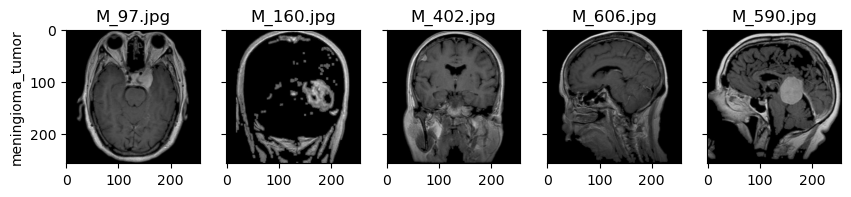

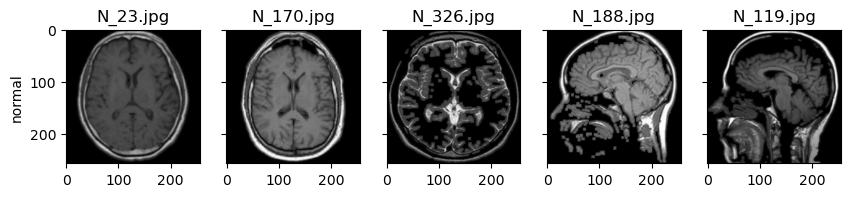

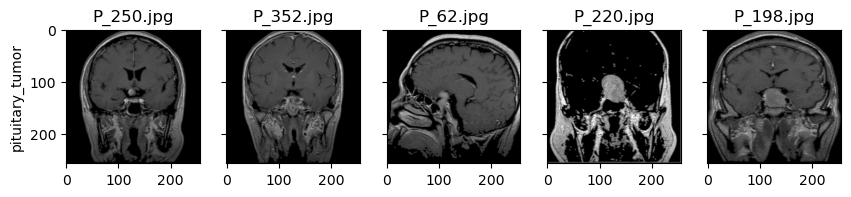

In [20]:
directory = os.listdir(path)

for each in disease.keys():
    plt.figure(figsize=(10, 10))
    currentFolder = path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = path + '/' + each + "/" + file
        img=cv2.imread(fullpath)
        ax=plt.subplot(1,5,i+1)
        ax.set_title(file)
        if(i == 0):
            ax.set_ylabel(each)
        else:
            ax.set_yticklabels([])
        plt.imshow(img)

In [21]:
%%time
X = []
y = []
for name, diseases in tqdm(disease.items()):
    for disease in diseases:
        img = cv2.imread(str(disease))
        img = img.astype('float32') / 255.0
        X.append(img)
        y.append(labels[name])

100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

CPU times: user 2.8 s, sys: 770 ms, total: 3.57 s
Wall time: 4.46 s


In [ ]:
X = torch.tensor(X)
y = torch.tensor(y)

## Treinamento

In [7]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size = 0.2, random_state = 42)

# get 20% from train set and and extract a new validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [8]:
# Normalização
m = np.max(X_train)
X_train = X_train/m
X_test = X_test/m

In [9]:
# make binary categorization labels
hot = OneHotEncoder()
# '-1' get the length of array 
y_train = hot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = hot.fit_transform(y_val.reshape(-1, 1)).toarray()
y_test = hot.transform(y_test.reshape(-1, 1)).toarray()

In [10]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (1980, 256, 256, 3)
Shape of X_val:  (496, 256, 256, 3)
Shape of X_test:  (620, 256, 256, 3)
Shape of y_train:  (1980, 4)
Shape of y_val:  (496, 4)
Shape of y_test:  (620, 4)


In [11]:
from keras.layers import Dense, Flatten, Conv2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

input_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]

seq_net = Sequential()
seq_net.add(Conv2D(filters=1, \
                    kernel_size=3, \
                    activation='relu', \
                    input_shape=input_shape))

seq_net.add(Flatten())
seq_net.add(Dense(64,activation='relu'))
seq_net.add(Dense(16,activation='relu'))
seq_net.add(Dense(4,activation='softmax'))


2023-11-03 15:05:33.337757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 15:05:33.337784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 15:05:33.337808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 15:05:33.344923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 15:05:35.568809: I tensorflow/compiler/

In [12]:
seq_net.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [13]:
X_train = np.expand_dims(X_train,axis=-1)
X_val = np.expand_dims(X_val,axis=-1)

In [14]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

history = seq_net.fit(X_train, y_train, 
                             epochs = 100, 
                             verbose = 1,
                             validation_data = (X_val, y_val),
                             callbacks=[es])

2023-11-03 15:05:38.161530: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1557135360 exceeds 10% of free system memory.
2023-11-03 15:05:48.820523: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB (rounded to 1557135360)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-03 15:05:48.820543: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-11-03 15:05:48.820550: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 20, Chunks in use: 20. 5.0KiB allocated for chunks. 5.0KiB in use in bin. 768B client-requested in use in bin.
2023-11-03 15:05:48.820555: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B alloc

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Teste e avaliação de desempenho

In [ ]:
from sklearn.metrics import accuracy_score

X_test = np.expand_dims(X_test,axis=-1)
y_pred = seq_net.predict(X_test)

accuracy_score(y_test.argmax(1), y_pred.argmax(1))

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(1), y_pred.argmax(1))